In [16]:
import numpy as np
import ctypes as ct
import cv2
import sys
import argparse
from completion import CompletionNet
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import os
import os.path
import errno
import torch
import json
import codecs
import ctypes as ct
import progressbar
import torchvision.transforms as transforms
import utils
import json
from numpy.linalg import inv
import pickle

%matplotlib inline

In [24]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def default_loader(path):
    img = Image.open(path).convert('RGB')
    return img

def depth_loader(path):
    img = Image.open(path).convert('I')
    return img


class ViewDataSet3D(data.Dataset):

    def __init__(self, root, train=True, transform=None, mist_transform=None, loader=default_loader, seqlen=5, debug=False, dist_filter = None, off_3d = True, off_pc_render = True):
        print ('Processing the data:')
        self.root = root.rstrip('/')
        #print(self.root)
        self.fofn = os.path.basename(self.root) + '_fofn'+str(int(train))+'.pkl'
        self.train = train
        self.loader = loader
        self.seqlen = seqlen
        self.transform = transform
        self.target_transform = transform
        self.depth_trans = mist_transform
        self.off_3d = off_3d
        self.select = []
        self.off_pc_render = off_pc_render
        if not self.off_pc_render:
            self.dll=np.ctypeslib.load_library('render','.')
        
        print(self.fofn)
        if not os.path.isfile(self.fofn):
            
            self.scenes = sorted([d for d in (os.listdir(self.root)) if os.path.isdir(os.path.join(self.root, d)) and os.path.isfile(os.path.join(self.root, d, 'sweep_locations.csv')) and os.path.isdir(os.path.join(self.root, d, 'pano'))])
            #print(self.scenes)
            num_scenes = len(self.scenes)
            num_train = int(num_scenes * 0.9)
            print("Total %d scenes %d train %d test" %(num_scenes, num_train, num_scenes - num_train))
            if train:
                self.scenes = self.scenes[:num_train]
            else:
                self.scenes = self.scenes[num_train:]


            self.bar  = progressbar.ProgressBar(widgets=[
                        ' [', progressbar.Timer(), '] ',
                        progressbar.Bar(),
                        ' (', progressbar.ETA(), ') ',
                        ])

            self.meta = {}
            if debug:
                last = 35
            else:
                last = len(self.scenes)

            for scene in self.scenes[:last]:
                posefile = os.path.join(self.root, scene, 'sweep_locations.csv')
                with open(posefile) as f:
                    for line in f:
                        l = line.strip().split(',')
                        if not self.meta.has_key(scene):
                            self.meta[scene] = {}
                        metadata = (l[0], map(float, l[1:4]), map(float, l[4:8]))

                        if os.path.isfile(os.path.join(self.root, scene, 'pano', 'points', 'point_' + l[0] + '.json')):
                            self.meta[scene][metadata[0]] = metadata
            print("Indexing")
        
            for scene, meta in self.bar(self.meta.items()):
                if len(meta) < self.seqlen:
                    continue
                for uuid,v in meta.items():
                    dist_list = [(uuid2, np.linalg.norm(np.array(v2[1]) - np.array(v[1]))) for uuid2,v2 in meta.items()]
                    dist_list = sorted(dist_list, key = lambda x:x[-1])

                    if not dist_filter is None:
                        if dist_list[1][-1] < dist_filter:
                            self.select.append([[scene, dist_list[i][0], dist_list[i][1]] for i in range(self.seqlen)])

                    else:
                        self.select.append([[scene, dist_list[i][0], dist_list[i][1]] for i in range(self.seqlen)])                
            
            with open(self.fofn, 'wb') as fp:
                pickle.dump([self.scenes, self.meta, self.select, num_scenes, num_train], fp)
                
        else:
            with open(self.fofn, 'rb') as fp:
                self.scenes, self.meta, self.select, num_scenes, num_train = pickle.load(fp)
                print("Total %d scenes %d train %d test" %(num_scenes, num_train, num_scenes - num_train))
                
            
    def __getitem__(self, index):
        #print(index)
        scene = self.select[index][0][0]
        #print(scene)
        uuids = [item[1] for item in self.select[index]]
        #print(uuids)
        #poses = ([self.meta[scene][item][1:] for item in uuids])
        #poses = [item[0] + item[1] for item in poses]
        #poses = [torch.from_numpy(np.array(item, dtype=np.float32)) for item in poses]
        paths = ([os.path.join(self.root, scene, 'pano', 'rgb', "point_" + item + "_view_equirectangular_domain_rgb.png") for item in uuids])
        mist_paths = ([os.path.join(self.root, scene, 'pano', 'mist', "point_" + item + "_view_equirectangular_domain_mist.png") for item in uuids])
        normal_paths = ([os.path.join(self.root, scene, 'pano', 'normal', "point_" + item + "_view_equirectangular_domain_normal.png") for item in uuids])
        pose_paths = ([os.path.join(self.root, scene, 'pano', 'points', "point_" + item + ".json") for item in uuids])
        #print(paths)
        poses = []
        #print(pose_paths)
        for item in pose_paths:
            f = open(item)
            pose_dict = json.load(f)
            p = np.concatenate(np.array(pose_dict[0][u'camera_rt_matrix'] + [[0,0,0,1]])).astype(np.float32).reshape((4,4))
            #print(p,p.shape)

            poses.append(p)
            f.close()

        img_paths = paths[1:]
        target_path = paths[0]
        img_poses = poses[1:]
        target_pose = poses[0]

        mist_img_paths = mist_paths[1:]
        mist_target_path = mist_paths[0]

        normal_img_paths = normal_paths[1:]
        normal_target_path = normal_paths[0]
        poses_relative = []

        for item in img_poses:
            relative = np.dot(item, inv(target_pose))
            #poses_relative.append(torch.from_numpy(np.concatenate(utils.transfromM(relative), 0).astype(np.float32)))
            poses_relative.append((item, target_pose))
        #print(poses_relative)

        imgs = [self.loader(item) for item in img_paths]
        target = self.loader(target_path)

        if not self.off_3d:
            mist_imgs = [depth_loader(item) for item in mist_img_paths]
            mist_target = depth_loader(mist_target_path)

            normal_imgs = [self.loader(item) for item in normal_img_paths]
            normal_target = self.loader(normal_target_path)

        org_img = imgs[0].copy()
        
        if not self.transform is None:
            imgs = [self.transform(item) for item in imgs]
        if not self.target_transform is None:
            target = self.target_transform(target)

        if not self.off_3d:
            
            mist_imgs = [np.expand_dims(np.array(item).astype(np.float32)/65536.0, 2) for item in mist_imgs]        
            org_mist = mist_imgs[0][:,:,0].copy()
            mist_target = np.expand_dims(np.array(mist_target).astype(np.float32)/65536.0,2)
            
            if not self.depth_trans is None:
                mist_imgs = [self.depth_trans(item) for item in mist_imgs]
            if not self.depth_trans is None:
                mist_target = self.depth_trans(mist_target)

            if not self.transform is None:
                normal_imgs = [self.transform(item) for item in normal_imgs]
            if not self.target_transform is None:
                normal_target = self.target_transform(normal_target)
        
        if not self.off_pc_render:
            img = np.array(org_img)
            h,w,_ = img.shape
            render=np.zeros((h,w,3),dtype='uint8')
            target_depth = np.zeros((h,w)).astype(np.float32)
            
            depth = org_mist
            pose = poses_relative[0].numpy()
            x = -pose[1]
            y = -pose[0]
            z = -pose[2]
            yaw = pose[-1] + np.pi
            pitch = pose[-3] # to be verified
            roll = pose[-2] # to be verified
            p = np.array([x,y,z,pitch,yaw,roll]).astype(np.float32)
            self.dll.render(ct.c_int(img.shape[0]),
                   ct.c_int(img.shape[1]),
                   img.ctypes.data_as(ct.c_void_p),
                   depth.ctypes.data_as(ct.c_void_p),
                   p.ctypes.data_as(ct.c_void_p),
                   render.ctypes.data_as(ct.c_void_p),
                   target_depth.ctypes.data_as(ct.c_void_p)
                  ) 
            if not self.transform is None:
                render = self.transform(Image.fromarray(render))
            if not self.depth_trans is None:
                target_depth = self.depth_trans(np.expand_dims(target_depth,2))
        
        if self.off_3d:
            return imgs, target, poses_relative
        elif self.off_pc_render:
            return imgs, target, mist_imgs, mist_target, normal_imgs, normal_target,  poses_relative
        else:
            return imgs, target, mist_imgs, mist_target, normal_imgs, normal_target,  poses_relative, render, target_depth
    
    def __len__(self):
        return len(self.select)


In [348]:
parser = argparse.ArgumentParser()
parser.add_argument('--debug'  , action='store_true', help='debug mode')
parser.add_argument('--dataroot'  , required = True, help='dataset path')
parser.add_argument('--idx'  , type = int, default = 0, help='index of data')
parser.add_argument('--model'  , type = str, default = '', help='path of model')


opt = parser.parse_args(["--dataroot", "/home/fei/Development/data/viewsyn_tiny/", "--idx", "100"])

d = ViewDataSet3D(root=opt.dataroot, transform = np.array, mist_transform = np.array, seqlen = 2, off_3d = False)
idx = opt.idx
source = d[idx][0][0]
target = d[idx][1]
source_depth = d[idx][2][0]
source_pose, target_pose = d[idx][-1][0]

Processing the data:
viewsyn_tiny_fofn1.pkl
Total 10 scenes 9 train 1 test


In [349]:
poses

(array([[  1.42633900e-01,   9.89775419e-01,   4.36012953e-04,
           7.24467874e-01],
        [ -9.89019275e-01,   1.42507687e-01,   3.91461030e-02,
           6.20469749e-01],
        [  3.86837162e-02,  -6.01478666e-03,   9.99233425e-01,
          -4.25996065e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e+00]], dtype=float32),
 array([[-0.82663369,  0.55963254, -0.05906091,  2.07728982],
        [-0.56027186, -0.82828194, -0.00667024, -0.09532433],
        [-0.05265196,  0.02757632,  0.99823207, -4.07876682],
        [ 0.        ,  0.        ,  0.        ,  1.        ]], dtype=float32))

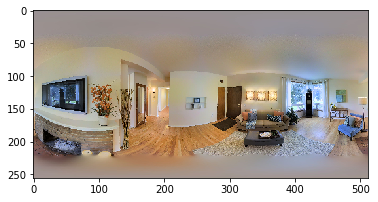

In [350]:
plt.imshow(source)

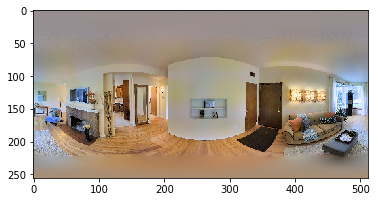

In [351]:
plt.imshow(target)

In [352]:
source.shape

(256, 512, 3)

In [381]:
def transform(source, source_depth, pose_matrix):
    h,w = 256,512
    theta = np.expand_dims(((np.arange(512) + 0.5) / 512.0), 0).repeat(256,0) * np.pi * 2 - np.pi
    phi = np.expand_dims(((np.arange(256) + 0.5) / 256.0), 1).repeat(512,1) * np.pi
    r = source_depth * 128.0
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    points = np.stack([x.flatten(), y.flatten(), z.flatten(), np.ones(256 * 512)])
    points = np.dot(pose_matrix, points)
    #print(np.mean(points[3,:]))
    points = points[0:3, :].reshape((3,256,512))
    x2, y2, z2 = points[0,:], points[1,:], points[2,:] 
    
    theta2 = np.arctan2(y2, x2)
    phi2 = np.arctan2(np.sqrt(x2 ** 2 + y2 ** 2), z2)
    
    theta2 = np.round((theta2 + np.pi) / (2 * np.pi) * 512 - 0.5)
    phi2 = np.round((phi2/np.pi) * 256 - 0.5)
    
    print(theta2, phi2)
    
    theta2 = theta2.astype(np.int)
    phi2 = phi2.astype(np.int)
    
    target = np.zeros(source.shape)
    
    for i in range(h):
        for j in range(w):
            target[phi2[i,j], theta2[i,j], :] = source[i,j,:]
            
    target = target.astype(np.uint8)
    return target, theta, phi

In [464]:
pose = np.dot(source_pose, inv(target_pose))
pose = np.dot( np.array([[0,1,0,0],[1,0,0,0],[0,0,1,0],[0,0,0,1]]), pose)
pose[:3,:3] = np.eye(3)
print(pose)
t,theta,phi = transform(source, source_depth[:,:,0], pose)

[[ 1.          0.          0.         -1.1282568 ]
 [ 0.          1.          0.         -0.27407539]
 [ 0.          0.          1.          0.00521791]
 [ 0.          0.          0.          1.        ]]
[[ 19.  19.  19. ...,  19.  19.  19.]
 [ 19.  19.  19. ...,  19.  19.  19.]
 [ 18.  18.  19. ...,  18.  18.  18.]
 ..., 
 [ 18.  18.  18. ...,  18.  18.  18.]
 [ 18.  18.  18. ...,  18.  18.  18.]
 [ 19.  19.  19. ...,  19.  19.  19.]] [[  71.   71.   71. ...,   71.   71.   71.]
 [  71.   71.   71. ...,   71.   71.   71.]
 [  72.   72.   72. ...,   72.   72.   72.]
 ..., 
 [ 203.  203.  203. ...,  203.  203.  203.]
 [ 204.  204.  204. ...,  204.  204.  204.]
 [ 204.  204.  204. ...,  204.  204.  204.]]


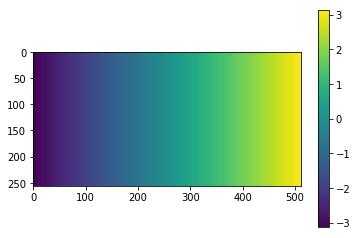

In [465]:
plt.imshow(theta)
plt.colorbar()

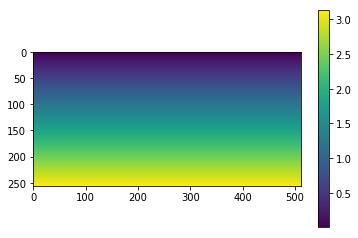

In [466]:
plt.imshow(phi)
plt.colorbar()

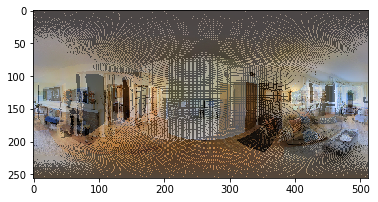

In [467]:
plt.imshow(((t.astype(np.float32) + target.astype(np.float32))/2).astype(np.uint8))

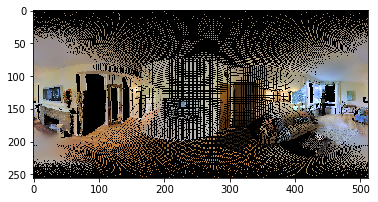

In [468]:
plt.imshow(t)

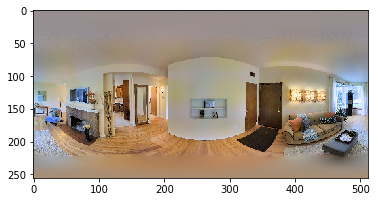

In [469]:
plt.imshow(target)